In [1]:
import scanpy as sc
import scvelo as scv
import numpy as np

In [3]:
adata = sc.read('../../../../../../media/spencer/Seagate Backup Plus Drive/scRNAseq/lung/raw_c2/c2_anndata.h5ad')
adata.obs['annotations'] = adata.obsm['Clusters'][:,0]
adata.obs.annotations = adata.obs.annotations.astype('category')

import pandas as pd
meta = pd.read_csv('../../../../../../media/spencer/Seagate Backup Plus Drive/scRNAseq/lung/raw_c2/c2_metadata_Aug19.csv',
                  index_col=0)

umap = pd.read_csv('../../../../../../media/spencer/Seagate Backup Plus Drive/scRNAseq/lung/raw_c2/c2_Embeddings.csv',
                  index_col=0)

adata.obs['id'] = [str(x.split('-')[0]) +'-'+ str(x.split('-')[1]) for x in adata.obs.index.values]
adata.obs = adata.obs.set_index('id')

adata.obs['cell_type'] = meta['cell_type']
adata.obs['cell_type_num'] = meta['cell_type_Aug']

adata.obs['UMAP1'] = umap['UMAP_1']
adata.obs['UMAP2'] = umap['UMAP_2']
adata.obsm['X_umap'] = np.array([adata.obs.UMAP1, adata.obs.UMAP2]).T


GW = np.array([float(x.split('_')[1][:2]) for x in meta['sample_name']])
D = np.array([0 if len(x.split('_')) == 2 else float(x.split('_')[2]) for x in meta['sample_name']])
meta['GW'] = [str(int(GW[i])) + '.' + str(int(D[i])) for i in range(len(GW))]#/7.0)
meta['GD'] = [GW[i]+D[i]/7.0 for i in range(len(GW))]#/7.0)
adata.obs['GW'] = meta['GW']
adata.obs['GD'] = meta['GD']


adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
adata.obs['cell_type_num'] = adata.obs['cell_type_num'].astype('category')

adata.obs['cell_type'] = adata.obs['cell_type'].cat.rename_categories({'SOX2+CFTR+ 2 cells': 'SOX2highCFTR+ cells',
                                                                      'SOX2+CFTR+ 1 cells': 'SOX2lowCFTR+ cells'})

adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
adata.obs['cell_type_num'] = adata.obs['cell_type_num'].astype('category')

adata.obs['sample_week'] = meta['sample_week']

adata = adata[~adata.obs.cell_type.isin(['SMG basal cells', 'SMG secretory cells',
                                          'NRGN+ cells', 'Schwann'])]
adata = adata[~adata.obs['cell_type'].isna()]

sc.pp.filter_genes(adata, min_cells=10)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [5]:
degs = pd.read_excel('../../../../../../media/spencer/Seagate Backup Plus Drive/scRNAseq/lung/raw_c2/Wong_Fetal_Lung_Dataset_August_2023_sept3.xlsx', 
                     sheet_name='Epithelial')

In [8]:
adata.obs['Gestational week'] = ['GW'+x for x in adata.obs.GW.astype(str)]
adata.obs.GW = adata.obs.GW.astype(float)

In [9]:
adata.obs.GD = adata.obs.GD.astype(float)
adata.obs.GW = adata.obs.GW.astype(float)

In [10]:
adata.obs['Gestational week'] = ['GW'+x for x in adata.obs.GW.astype(str)]
adata.obs.GW = adata.obs.GW.astype(float)

In [11]:
import matplotlib.pyplot as plt

import seaborn as sns 
import matplotlib as mpl

palette = mpl.colormaps['coolwarm'] 
import matplotlib.patches as mpatches
import seaborn as sns
min=np.min(adata.obs.GW.values)
max=np.max(adata.obs.GW.values)
legend_colors = [mpatches.Patch(color=palette((c-min)/(max-min)), 
                                label=l) for c,l in adata.obs[['GW','Gestational week']].drop_duplicates().values]

palette = [palette((c-min)/(max-min)) for c in adata.obs.GW.unique()]

In [12]:
adata.obs['time_groups'] = 0
time_groups = []
for i in range(adata.shape[0]):
    if adata[i].obs.sample_week.isin(['week_10', 'week_11', 'week_12', 'week_13']).item():
        time_groups.append('GW 10-13')
    if adata[i].obs.sample_week.isin(['week_14', 'week_15', 'week_16']).item():
        time_groups.append('GW 14-16')
    if adata[i].obs.sample_week.isin(['week_17', 'week_18', 'week_19']).item():
        time_groups.append('GW 17-19')
adata.obs['time_groups'] = time_groups

In [13]:
import gc
adata.layers['spliced'] = adata.X.copy()
adata.layers['unspliced'] = adata.X.copy()
gc.collect()
scv.pp.neighbors(adata, n_pcs=30, n_neighbors=100)#300#100)
gc.collect()#
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)
gc.collect()

computing neighbors
    finished (0:01:52) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:29) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


0

In [14]:
pnec_markers = ['GRP',
 'PCSK1N',
 'SEC11C',
 'BEX1',
 'SCG3',
 'HES6',
 'ASCL1',
 'PROX1',
 'CHGB',
 'HEPACAM2',
 'CHGA',
 'NRXN1',
 'SCG2',
 'UCHL1',
 'SCGN',
 'NEUROD1',
 'CALCA',
 'CACNA1A',
 'INSM1']

In [15]:
ciliated_markers = ['CAPS',
 'C20orf85',
 'C9orf24',
 'TMEM190',
 'RSPH1',
 'SNTN',
 'TSPAN1',
 'DNAH5',
 'MORN2',
 'FOXJ1',
 'TUBA1A',
 'FAM183A',
 'PIFO',
 'AL357093.2',
 'AGR3',
 'C11orf88',
 'CCDC170',
 'DNAAF1',
 'ERICH3']

In [16]:
selected = adata[:,pnec_markers+ciliated_markers]
gc.collect()

0

In [17]:
xkey = 'Ms'#X'
time = selected.obs['Gestational week'].values
var_names = pnec_markers+ciliated_markers
n_convolve=100
X = selected[:, var_names].layers[xkey] if xkey in selected.layers.keys() else selected[:, var_names].X
from scipy.sparse import issparse
if issparse(X): X = X.A
df = pd.DataFrame(X[np.argsort(time)], columns=var_names)

if n_convolve is not None:
        weights = np.ones(n_convolve) / n_convolve
        for i, gene in enumerate(var_names):
            try:
                df[gene] = np.convolve(df[gene].values, weights, mode='same')
            except: pass  
selected.layers['smoothed'] = df 

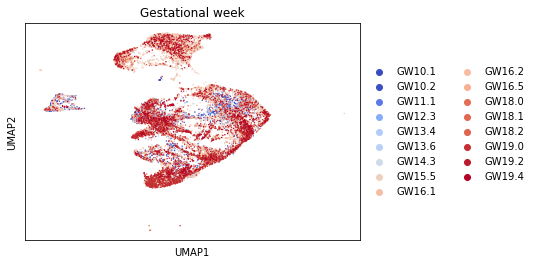

In [18]:
sc.pl.umap(selected, color='Gestational week', palette=palette)

{'heatmap_ax': <AxesSubplot:>, 'groupby_ax': <AxesSubplot:ylabel='Gestational week'>, 'gene_groups_ax': <AxesSubplot:>}


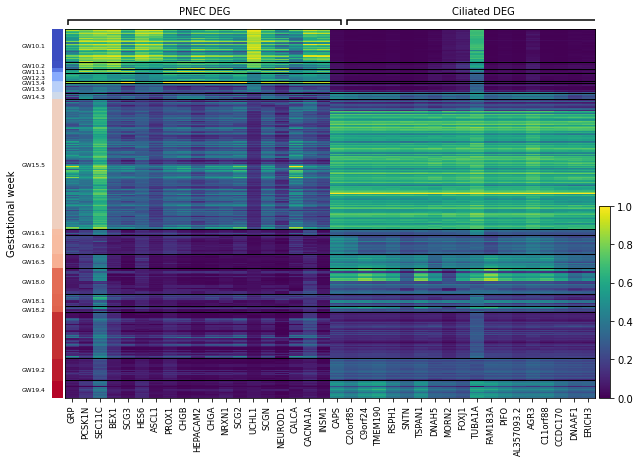

In [20]:
import matplotlib.pyplot as plt
import gc
gc.collect()

im= sc.pl.heatmap(selected, layer='smoothed', standard_scale='var',#'smoothed',
             var_names=pnec_markers+ciliated_markers, groupby='Gestational week', 
              var_group_positions=[(0,19), (20, 39)], 
              var_group_labels=['PNEC DEG', 'Ciliated DEG'],
            figsize=(10,7), 
             var_group_rotation=0, show=False)
print(im)
im['groupby_ax'].tick_params(labelsize=6)
plt.tight_layout()
plt.savefig('figures/Triplepos_pnec_ciliated_heatmap.pdf', bbox_inches='tight')
plt.show()

In [21]:
pd.DataFrame(selected[:,pnec_markers+ciliated_markers].layers['smoothed'],
             index=selected.obs['Gestational week'],
            columns=list(pnec_markers+ciliated_markers)).to_csv('data/PNEC_Ciliated_TP_heatmap.csv')